# By Ali Kakhbod and Philip Livdan
## UC Berkeley

*Warning: This notebook can take ~2h to run on a GPU*

# Introduction
Decoders play a pivotal role in the field of Natural Language Processing (NLP) and Machine Learning, especially when it comes to sequence-to-sequence models. A common application of decoders is in language generation tasks, where we aim to produce coherent and contextually relevant sequences of text.

In this notebook, we will explore decoders by building a bigram model. The bigram model is a type of probabilistic language model that predicts the next item in a sequence based on the previous one. To make things even more interesting, we'll be using a subset of Shakespeare's literary works, known as the "tinyshakespeare" dataset.

By the end of this exploration, you will have a deeper understanding of:

- How bigram models function.
- How to prepare and preprocess textual data for such models.
- Building and training a decoder-based model using TensorFlow.

Import necessary modules:

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
import numpy as np
import requests
import matplotlib.pyplot as plt

#resize charts to fit screen if using Jupyter Notebook
plt.rcParams['figure.figsize']=[20,5]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

We're going to download the tinyshakespeare dataset from github. It provides a subset of the legendary playwright William Shakespeare's writings, encompassing a variety of plays, sonnets, and other literary pieces.

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

if response.status_code == 200:
    with open("input.txt", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [4]:
# hyperparameters
batch_size = 32 
block_size = 64 
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = tf.device('GPU:0' if tf.config.experimental.list_physical_devices('GPU') else 'CPU:0')
eval_iters = 200
n_embd = 128
n_head = 12
n_layer = 8
dropout = 0.2

tf.random.set_seed(1337)

In [5]:
# Loading dataset
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

### UTF-8: Unicode Transformation Format 8-bit
UTF-8 is a way to represent text that includes characters from all languages and writing systems. It can handle different characters using a variable number of bytes.

We use 'utf-8' encoding when loading the dataset to ensure that all characters in the text file are correctly read and processed. It prevents any decoding errors and allows us to work smoothly with the text data in our Python code.

# A Glimpse of Shakespeare's Works
To get a feel for the data we're working with, let's peek into the initial portion of our dataset. This will give us a sense of the style, structure, and complexity of Shakespeare's writings.

In [6]:
# let's look at the first 100 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


# Encoding 

Now we need turn our text into a format which the machine can understand. This is done through encoding. This is a very simple way of encoding the text:

It starts by extracting unique characters from the text dataset and creating dictionaries to map characters to integers and vice versa. The 'encode' function converts text into integer sequences, and the 'decode' function converts integer sequences back into human-readable text. These utilities enable numerical representation and processing of character-level text, facilitating tasks like character-level language modeling and text generation.

In [8]:
# create a mapping from characters to integers
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

Let's check if we are encoding and decoding correctly. 

In [9]:
print(encode("Go Bears!"))
print(decode(encode("Go Bears!")))

[19, 53, 1, 14, 43, 39, 56, 57, 2]
Go Bears!


Looking good!

# Preparing Data for TensorFlow

With our encoding process verified, our next step is to transform the entire "tinyshakespeare" dataset into its numeric representation. This numeric dataset is what we'll feed into our model.

We'll allocate 90% of our data for training and the remaining 10% for validation. This split ensures a good balance between training data availability and model validation.


In [10]:
# Train and test splits
data = np.array(encode(text), dtype=np.int32)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [11]:
print(data.shape, data.dtype)
print(data[:100]) # the 100 characters we looked at earier will look like this to the GPT

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]


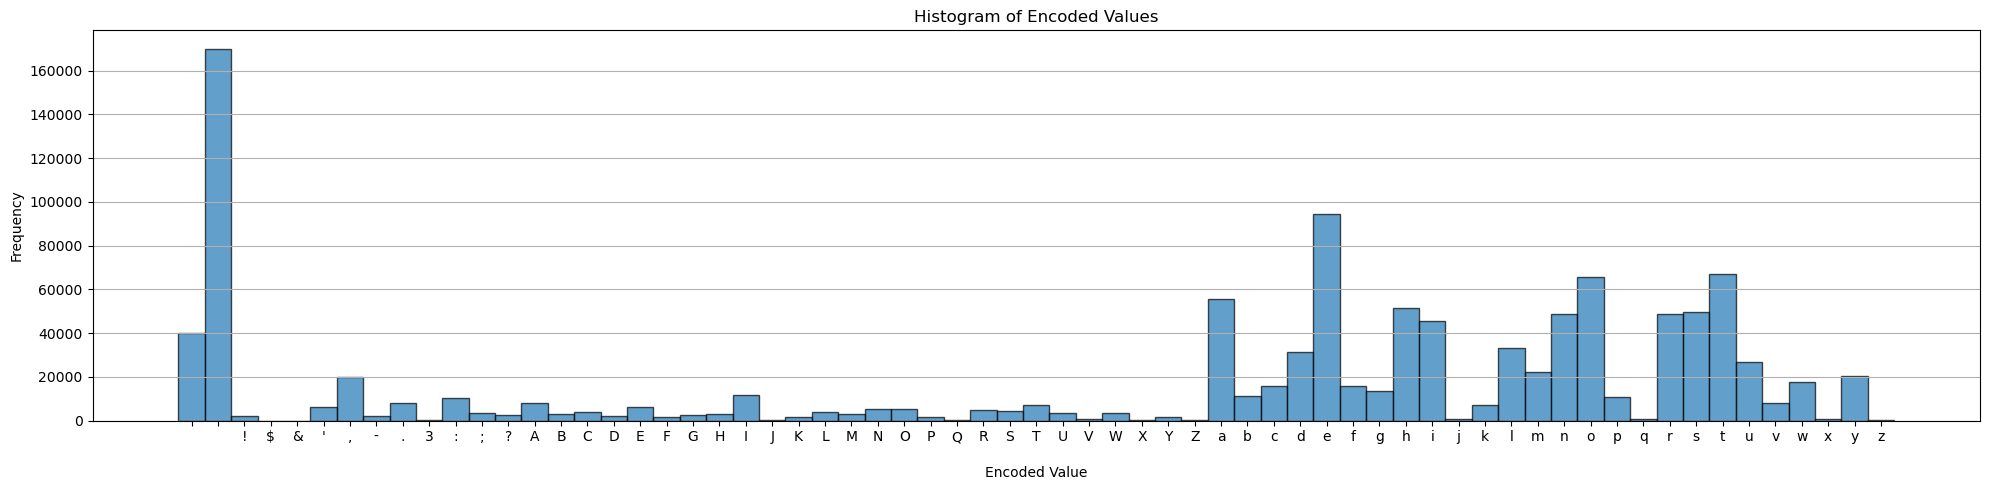

In [12]:
# Extracting the encoded values from the train_data for visualization
encoded_values = data

# Plotting the histogram
plt.hist(encoded_values, bins=range(len(chars)+1), alpha=0.7, edgecolor='black', align='left')
plt.title('Histogram of Encoded Values')
plt.xlabel('Encoded Value')
plt.ylabel('Frequency')
plt.xticks(range(len(chars)), chars)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

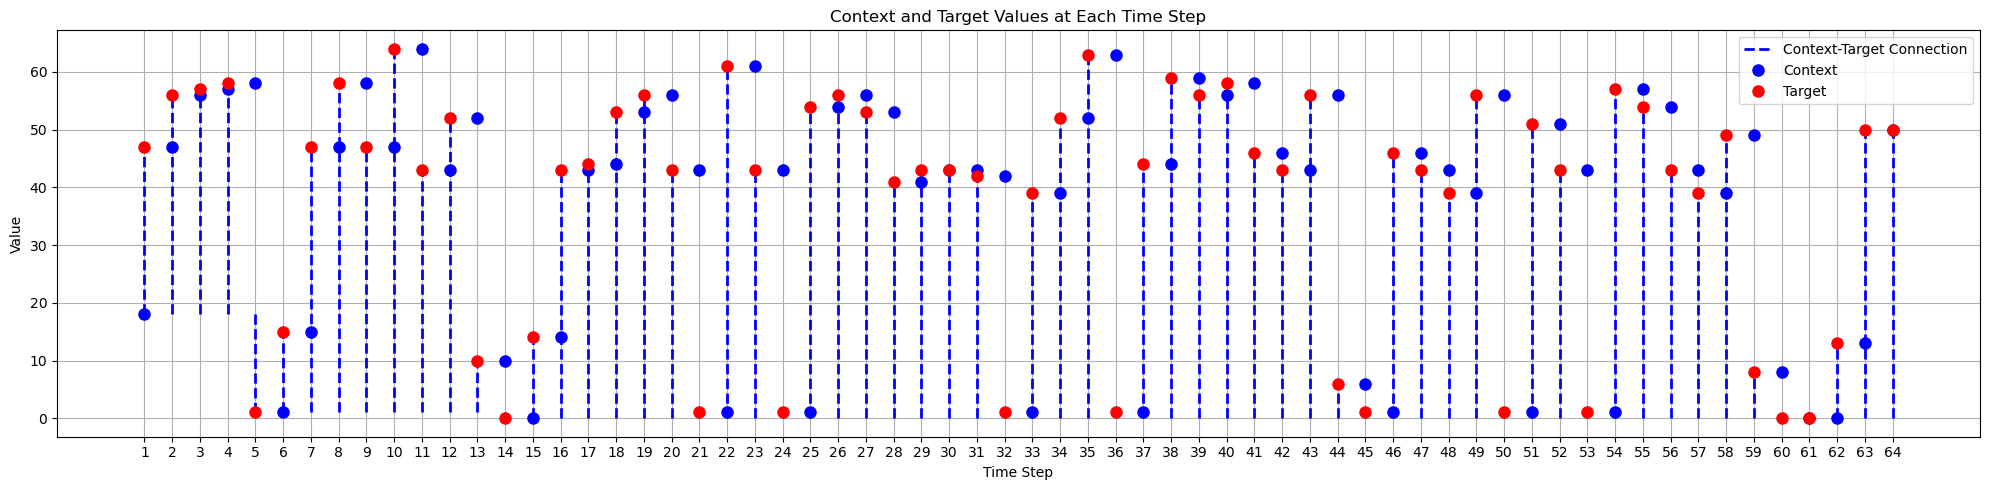

In [13]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
num_steps = len(x)

for t in range(num_steps):
    context = x[:t+1]
    target = y[t]
    plt.plot([t, t], [min(context), target], 'b--', linewidth=2)
    plt.plot(t, context[-1], 'bo', markersize=8)
    plt.plot(t, target, 'ro', markersize=8)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Context and Target Values at Each Time Step')
plt.xticks(range(num_steps), range(1, num_steps + 1))
plt.legend(['Context-Target Connection', 'Context', 'Target'])
plt.grid(True)
plt.tight_layout()
plt.show()

- The blue circles represent the first word or phrase in the bigram (the context), which is a phrase or word from Shakespeare's writings.
- The red dots represent the second word or phrase in the bigram (the target), which is the word or phrase that follows the context in Shakespeare's writings.

For example, if you see a blue circle at "To be" and a red dot at "or not" connected by a vertical dashed line, it means that in the Shakespeare dataset, the phrase "To be" appears as a context, and it is followed by the target phrase "or not."

In [14]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(0, len(data) - block_size, batch_size)
    x = np.stack([data[i:i+block_size] for i in ix])
    y = np.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [15]:
def estimate_loss(model, loss_fn):
    out = {}
    for split in ['train', 'val']:
        losses = []
        for _ in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X)
            loss_value = loss_fn(Y, logits)
            losses.append(loss_value.numpy())
        out[split] = np.mean(losses)
    return out

# Model
---
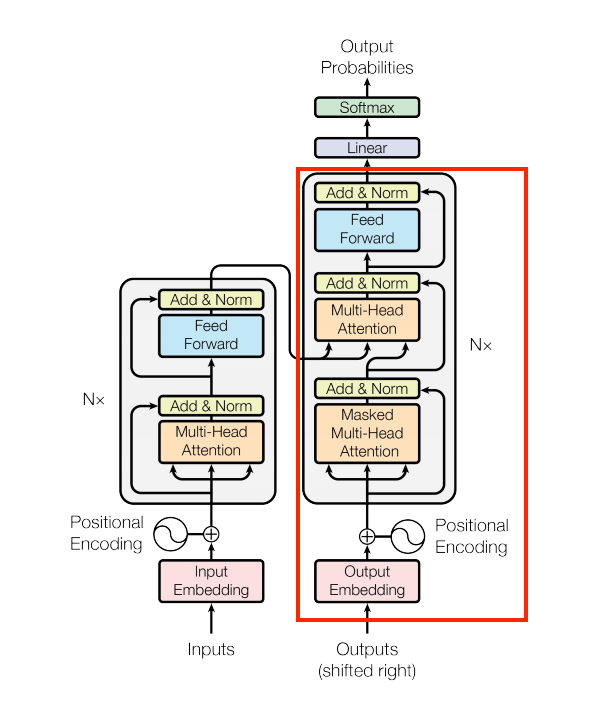

## The Head 
In the multi-head attention mechanism, the concept of "heads" is introduced. Each head learns different attention patterns, thereby capturing various aspects of the data. A single head consists of:

- **Key:** Represents the features of the input data.
- **Query:** Corresponds to the features of the output data.
- **Value:** Maps the relevance between the key and query.

In [16]:
# Head
class Head(layers.Layer):
    def __init__(self, head_size):
        super(Head, self).__init__()
        self.key = layers.Dense(head_size, use_bias=False)
        self.query = layers.Dense(head_size, use_bias=False)
        self.value = layers.Dense(head_size, use_bias=False)
        self.tril = tf.linalg.band_part(tf.ones((block_size, block_size)), -1, 0)
        self.dropout = layers.Dropout(dropout)

    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = tf.matmul(q, k, transpose_b=True) * C**-0.5
        wei = tf.where(self.tril[:T, :T] == 0, float('-inf'), wei)
        wei = tf.nn.softmax(wei, axis=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = tf.matmul(wei, v)
        return out

## Multi-Head Attention Layer

Multiple heads are combined to form the multi-head attention layer. The results from all heads are concatenated and passed through a linear layer to produce the final output.

In [17]:
# MultiHeadAttention Layer
class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, head_size):
        super(MultiHeadAttention, self).__init__()
        self.heads = [Head(head_size) for _ in range(num_heads)]
        self.proj = layers.Dense(n_embd)
        self.dropout = layers.Dropout(dropout)

    def call(self, x):
        out = tf.concat([h(x) for h in self.heads], axis=-1)
        out = self.dropout(self.proj(out))
        return out

## Feed-Forward Layer

This layer is a standard feed-forward neural network that's applied to the output of the multi-head attention layer. It further processes the data and can learn patterns within the sequence.

In [18]:
# FeedForward Layer
class FeedFoward(layers.Layer):
    def __init__(self, n_embd):
        super(FeedFoward, self).__init__()
        self.net = tf.keras.Sequential([
            layers.Dense(4 * n_embd, activation='relu'),
            layers.Dense(n_embd),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        return self.net(x)

## Transformer Block

The transformer block is a combination of the multi-head attention layer followed by a feed-forward layer. This structure allows the model to learn both attention patterns and sequence patterns, making it highly effective for tasks like language modeling.

In [19]:
# Transformer Block
class Block(layers.Layer):
    def __init__(self, n_embd, n_head):
        super(Block, self).__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [20]:
# BigramLanguageModel Model
class BigramLanguageModel(tf.keras.Model):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super(BigramLanguageModel, self).__init__()
        self.token_embedding_table = layers.Embedding(vocab_size, n_embd)
        self.position_embedding_table = layers.Embedding(block_size, n_embd)
        self.blocks = tf.keras.Sequential([Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = layers.LayerNormalization(epsilon=1e-6)
        self.lm_head = layers.Dense(vocab_size)

    def call(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(tf.range(T))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is not None:
            logits = tf.reshape(logits, [B*T, -1])
            targets = tf.reshape(targets, [B*T])
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
            return logits, loss
        return logits, None

In [21]:
model = BigramLanguageModel(vocab_size, n_embd, block_size, n_head, n_layer)
# Define loss and optimizer
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate)
# Build the model
model.build(input_shape=(batch_size, block_size))

model.summary()

Model: "bigram_language_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8320      
                                                                 
 embedding_1 (Embedding)     multiple                  8192      
                                                                 
 sequential_8 (Sequential)   (32, 64, 128)             1550336   
                                                                 
 layer_normalization_16 (Lay  multiple                 256       
 erNormalization)                                                
                                                                 
 dense_312 (Dense)           multiple                  8385      
                                                                 
Total params: 1,575,489
Trainable params: 1,575,489
Non-trainable params: 0
___________________________________

In [22]:
# Training Loop
for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model, loss_fn)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss and perform backpropagation
    with tf.GradientTape() as tape:
        logits, loss = model(xb, yb)

    # compute gradients and update model parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

step 0: train loss 4.9789, val loss 4.9869
step 100: train loss 2.6804, val loss 2.6937
step 200: train loss 2.4685, val loss 2.4674
step 300: train loss 2.3220, val loss 2.3357
step 400: train loss 2.2102, val loss 2.2469
step 500: train loss 2.0914, val loss 2.1594
step 600: train loss 1.9874, val loss 2.0976
step 700: train loss 1.8907, val loss 1.9930
step 800: train loss 1.8120, val loss 1.9471
step 900: train loss 1.7581, val loss 1.9090
step 1000: train loss 1.7152, val loss 1.8821
step 1100: train loss 1.6647, val loss 1.8296
step 1200: train loss 1.6451, val loss 1.8069
step 1300: train loss 1.6080, val loss 1.7871
step 1400: train loss 1.5886, val loss 1.7800
step 1500: train loss 1.5725, val loss 1.7544
step 1600: train loss 1.5443, val loss 1.7282
step 1700: train loss 1.5296, val loss 1.7111
step 1800: train loss 1.5174, val loss 1.7104
step 1900: train loss 1.4999, val loss 1.7004
step 2000: train loss 1.4923, val loss 1.6952
step 2100: train loss 1.4730, val loss 1.6860


# Generating Text with the Model

Once our model is trained, it's capable of generating sequences of text. By feeding it an initial sequence or "seed", the model can predict subsequent characters or words, effectively generating text in a style similar to the training data. Given our dataset, the model aims to produce text reminiscent of Shakespeare's writings.

In our notebook, after training, we generate a sequence to observe the model's capability in replicating Shakespearean language.

In [23]:
# Text Generation
context = np.zeros((1, block_size), dtype=np.int32)  # Initialize context with zeros for the first block_size tokens
for _ in range(2000):
    # generate text one token at a time
    logits, _ = model(context[:, -block_size:])  # Pass only the last block_size tokens as input
    logits = logits[:, -1, :]  # take the logits for the last token
    predicted_token = tf.random.categorical(logits, num_samples=1, dtype=tf.int32)
    context = np.concatenate([context, predicted_token], axis=1)

generated_text = decode(context[0, block_size:].tolist())  # Remove the initial zeros and decode the generated tokens
print(generated_text)

UPOLIXEW:
Madam, and, believe us, you'll out on her,
As home in that wish'd-men yet her misled.

KING HENRY VI:
Yrave will provide it. But, fair.

GLOUCESTER:
Show you findsh, Before Take o'et him.

BUCKINGHAM:
Still that love pation for our enemies, and
I but a Lancaster lost prohoof: but the eyes of
In assome had country's power.

DUKE VINCENTIO:
Lie to you live; 'tis you?

LUCIO:
Did plant not yet, crown and heavy wrongs,
He other govern by the steel hour of France,
Why, and but in receposing with steeling,
And let me conted made pereds I am to fast:
how his chief busining?
I'll have to endreated to brass them and writteouget, for a this
way's hand bade the hot. Be
women well madestable, call understimitation:
 I promised and King Angelo.
The kings Lancaster, 'Till God,
And Edward with bloody times more glade one,
With take barrows; he will ha; I must therein we,
He bissoming; Edward is, to thy bathe steen;
One of that tear? answer, thou hast thou vard affection;
Realnon howilly wit

### References

1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In *Advances in neural information processing systems* (pp. 5998-6008).
   - [Link to the paper](https://arxiv.org/abs/1706.03762)

2. Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In *Advances in neural information processing systems* (pp. 3111-3119).
   - [Link to the paper](https://papers.nips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html)

3. TensorFlow Team. (n.d.). Text generation with an RNN. TensorFlow Tutorials.
   - [Link to the tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

4. Karpathy, A. (2015). The Unreasonable Effectiveness of Recurrent Neural Networks. Andrej Karpathy blog.
   - [Link to the blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

5. OpenAI Team. (n.d.). "tinyshakespeare" Dataset. OpenAI's Datasets.
   - [Link to the dataset](https://github.com/openai/gpt-2-output-dataset)
